# 3.6 Reconciling projections

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

## 3.6.1 Introduction

This section of notes is optional to the course, and the tutor may decide *not* to go through this in class. That said, the information and obexamples contained here can be very useful for accessing and processing certain types of geospatial data.

In particular, we deal with obtaining climate data records from [ECMWF](http://apps.ecmwf.int/datasets/data/era40-daily/levtype=sfc) that we will later use for model fitting. These data come in a [netcdf](https://confluence.ecmwf.int/display/CKB/What+are+NetCDF+files+and+how+can+I+read+them) format (commonly used for climate data) with a grid in latitude/longitude. To 'overlay' these data with another dataset (e.g. the MODIS LAI product that we have been using) in a different (equal area) projection, we use the `gdal` function

    gdal.ReprojectImage(src, dst, src_proj, dst_proj, interp)
       
where:

    src      : a source dataset that we want to process 
    dst      : a blank destination dataset that we set up with the 
               required (output) data type, shape, and geotransform and projection
    src_proj : the source dataset projection wkt 
    dst_proj : the destination projection wkt 
    interp   : the required interpolation method, e.g. gdalconst.GRA_Bilinear
    
where wkt stands for [well known text](https://en.wikipedia.org/wiki/Well-known_text) and is a projection format string.

Other codes we use are ones we have developed earlier.

In these notes, we will learn:

    * how to access an ECMWF daily climate dataset (from ERA interim)
    * how to reproject the dataset to match another spatial dataset (MODIS LAI)
    
We will then save some datasets that we will use later in the notes. For this reason, it's possile to skip this section, and return to it later.

## 3.6.1.1 Projections

For various reasons, different geospatial datasets will come in different [projections](http://desktop.arcgis.com/en/arcmap/10.3/guide-books/map-projections/what-are-map-projections.htm).

Considering for example satellite-derived data from Low Earth Orbit (LEO)[https://en.wikipedia.org/wiki/Low_Earth_orbit], the satellite sensor will typically obtain image data in a swath as it passes over the Earth surface. Projected onto the Earth surface, this appears as a strip of data:

![https://earthobservatory.nasa.gov/Features/LDCMLongSwath](images/long_swath_map_720.png)

but in the satellite data recording system, the data are stored as a regular array. We call such satellite data 'swath' (or 'swath-like') data (in the satellite imager coordinate system) and we may obtain data products in anything up to [Level 2](https://earthdata.nasa.gov/earth-science-data-systems-program/policies/data-information-policy/data-levels) in such a form.

These data are often difficult for data scientists to deal with. They generally prefer to have a dataset mapped to a uniform space-time grid, even though this may involve some re-sampling, which can sometimes result in loss of information. The convenience of a uniform space-time grid means that you can. for example, look at dynamic features (information over time).

The properties of the 'uniform space-time grid' will depend on [user requirements](http://desktop.arcgis.com/en/arcmap/10.3/tools/coverage-toolbox/choosing-a-map-projection.htm). For some, it is important to have an [equal area projection](https://www.giss.nasa.gov/tools/gprojector/help/projections/), one where the 'pixel size' is consistent throughout the dataset. 

![https://www.giss.nasa.gov/tools/gprojector/hehttps://www.giss.nasa.gov/tools/gprojector/help/projections/CylindricalEqualArea.png](images/CylindricalEqualArea.png)

even if this is not convenient for viewing some areas of the Earth (map projections are very political!).

For others, other factors may be more important, such as user familiarity with a simple latitude/longitude grid typically used by climate scientists. 

![https://www.giss.nasa.gov/tools/gprojector/help/projections/CylindricalStereographic.png](images/CylindricalStereographic.png)

For others, a conformal projection (preserving angles, as a cost of distance distortion) may be vital.

![https://www.giss.nasa.gov/tools/gprojector/help/projections/AdamsHemisphereInASquare.png](images/AdamsHemisphereInASquare.png)

We have see that MODIS data products, for example, come described in an equal area sinusoidal grid:

![https://www.giss.nasa.gov/tools/gprojector/help/projections/Sinusoidal.png](images/Sinusoidal.png).

but the data for high latitudes and longitudes appears very distorted.

We must accept then, that dealing with geospatial data must involve some understanding of projections, as well as practically, how to convert datasets between different projections.

## 3.6.1.2 Changing Projections

We can convenienty use the Python [`cartopy`](https://scitools.org.uk/cartopy/docs/v0.16/) package to explore projections.

We download an image taken from the satellite sensor ([SEVIRI](https://www.esa.int/Our_Activities/Observing_the_Earth/Meteosat/SEVIRI)):

![http://www.esa.int/spaceinimages/Images/2005/12/Artist_s_view_of_SEVIRI_in_orbit](images/Artist_s_view_of_SEVIRI_in_orbit_node_full_image_2.png)

The sensor builds up images of the Earth disc from geostationarty orbit, actioned by the platform spin.

![http://www.esa.int/spaceinimages/Images/2015/08/MSG-4_Europe_s_latest_weather_satellite_delivers_first_image](images/MSG-4_Europe_s_latest_weather_satellite_delivers_first_image_node_full_image_2.png)

In the code below, we plot the dataset in the 'earth disk' (Orthographic) projection, then re-map it to the equal area Sinusoidal projection.

In [ ]:
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen
from io import BytesIO
%matplotlib inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

'''
from https://scitools.org.uk/cartopy/docs/v0.16/\
            gallery/geostationary.html#sphx-glr-gallery-geostationary-py
'''
def geos_image():
    """
    Return a specific SEVIRI image by retrieving it from a github gist URL.

    Returns
    -------
    img : numpy array
        The pixels of the image in a numpy array.
    img_proj : cartopy CRS
        The rectangular coordinate system of the image.
    img_extent : tuple of floats
        The extent of the image ``(x0, y0, x1, y1)`` referenced in
        the ``img_proj`` coordinate system.
    origin : str
        The origin of the image to be passed through to matplotlib's imshow.

    """
    url = ('https://gist.github.com/pelson/5871263/raw/'
           'EIDA50_201211061300_clip2.png')
    img_handle = BytesIO(urlopen(url).read())
    img = plt.imread(img_handle)
    img_proj = ccrs.Geostationary(satellite_height=35786000)
    img_extent = [-5500000, 5500000, -5500000, 5500000]
    return img, img_proj, img_extent, 'upper'

print('Retrieving image...')
img, crs, extent, origin = geos_image()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1,projection=\
                     ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0))
ax.coastlines()
ax.set_global()
ax.imshow(img, transform=crs, extent=extent, origin=origin, cmap='gray')

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection=\
                     ccrs.Sinusoidal(central_longitude=0.0, \
                        false_easting=0.0, false_northing=0.0))
ax.coastlines()
ax.set_global()
print('Projecting and plotting image (this may take a while)...')
ax.imshow(img, transform=crs, extent=extent, origin=origin, cmap='gray')

The full list of [`cartopy` projections](https://scitools.org.uk/cartopy/docs/v0.16/crs/projections.html) is quite entensive.

**Exercise 3.6.1** (Homework)

* Explore some different types of projection using `cartopy` and make a note of their features.
* Read up (follow the links in the text above) on projections.

In [ ]:
#do exercise here

## 3.6.2 Requirements

We will need to:

* make sure we have the MODIS LAI dataset locally
* read them in for a given country.
* register with ecmwf, install ecmwfapi
* get the temperature datasset from ECMWF for 2006 and 2017 for Europe
* get the country borders shapefile

In [1]:
# required general imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import os
from pathlib import Path
import gdal
from datetime import datetime, timedelta

### 3.6.2.1 Run the pre-requisite scripts

**Make sure you register with ECMWF**
* register with ECMWF and install the API
    
    Follow the [ECMWF instructions](https://confluence.ecmwf.int/display/WEBAPI/Access+ECMWF+Public+Datasets)

**Sort data prerequisities** 
* Run the codes in the [prerequisites section](Chapter3_6A_GDAL_Reconciling_projections_prerequisites.ipynb)

    OR
    
* Run the [prerequisites script]:

In [2]:
# install ecmwf api -- do this once only
ECMWF = 'https://software.ecmwf.int/wiki/download/attachments/56664858/ecmwf-api-client-python.tgz'
try:
    from ecmwfapi import ECMWFDataServer
except:
    import os
    if os.name == 'nt':
        # on windows
        !pip install $ECMWF
    else:
        # on Unix/Linux
        !pip install --user $ECMWF

In [3]:
%run geog0111/Chapter3_6A_prerequisites.py

europe_data_2016_2017.nc exists


In [4]:
# read in the LAI data for given country code
country_code = 'UK'
year = 2017

tiles = []
for h in [17, 18]:
    for v in [3, 4]:
        tiles.append(f"h{h:02d}v{v:02d}")
        
fname = f'lai_data_{year}_{country_code}.npz'
ofile = Path('data')/fname
try:
    # read data from npz file
    lai = np.load(ofile)
except:
    print(f"{ofile} doesn't exist: sort the pre-requisites")

## 3.6.3 Reconcile the datasets

In this section, we will use `gdal` to transform two datasets into the same coordinate system.

To do this, we identify one dataset with the projection and geographic extent that we want for our data (a MODIS sub-dataset here, the 'exemplar').

We then download a climate dataset in a latitude/longitude grid ([netcdf](https://www.unidata.ucar.edu/software/netcdf/) format) and transform this to be consistent with the MODIS dataset.


### 3.6.3.1 load an exemplar dataset

Since we want to match up datasets, we need to produce an example of the dataset we want to match up to.

We save the exemplar as a GeoTiff format file here.

tmp/Lai_500m_2017_001_UK.tif


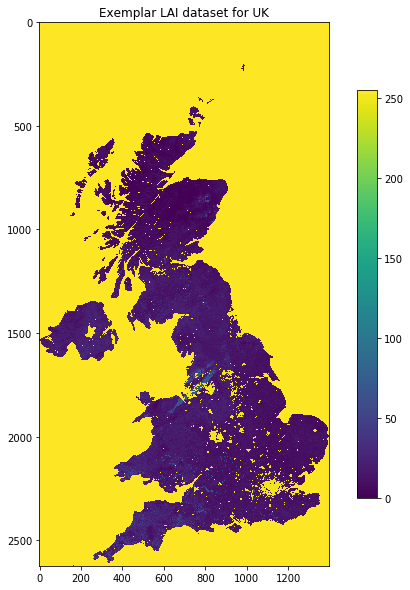

In [5]:
from osgeo import gdal, gdalconst,osr
import numpy as np
from geog0111.process_timeseries import mosaic_and_clip

country_code = 'UK'
shpfile = "data/TM_WORLD_BORDERS-0.3.shp"

'''
https://stackoverflow.com/questions/10454316/
how-to-project-and-resample-a-grid-to-match-another-grid-with-gdal-python
'''
        
# first get an exemplar LAI file, clipped to
# the required limits. We will use this to match  
# the t2 dataset to
match_filename = mosaic_and_clip(tiles,1,2017,ofolder='tmp',\
                    country_code=country_code,shpfile=shpfile,frmat='GTiff')

print(match_filename)

'''
Now get the projection, geotransform and dataset
size that we want to match to
'''
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

plt.figure(figsize=(10,10))
plt.title(f'Exemplar LAI dataset for {country_code}')
plt.imshow(match_ds.ReadAsArray())
plt.colorbar(shrink=0.75)
# close the file -- we dont need it any more
del match_ds

### 3.6.3.2 get information from source file


Now, we pull the information we need from the source file (the netcdf format t2 dataset).

We need to know:

* the data type
* the number of bands (time samples in this case)
* the geotransform of the dataset (the fact that it's 0.25 degree resolution over Europe)

and access these from the source dataset.



In [52]:
from osgeo import gdal, gdalconst,osr
import numpy as np

# set up conditions

src_filename = 'data/europe_data_2016_2017.nc'

'''
access information from source
'''
src_dataname = 'NETCDF:"'+src_filename+'":t2m'
src_latitude = 'NETCDF:"'+src_filename+'":latitude'
src_longitude = 'NETCDF:"'+src_filename+'":longitude'

src     = gdal.Open(src_dataname, gdalconst.GA_ReadOnly)

'''
Get geotrans, data type and number of bands
from source dataset
'''
band1 = src.GetRasterBand(1)
src_geotrans = src.GetGeoTransform()
nbands = src.RasterCount
src_format = band1.DataType

print('Information found')
print('GeoTransform:   ',src_geotrans)
print('number of bands:',nbands)
print('format:         ',src_format)

# visualise
t2m = band1.ReadAsArray()
src_lat = gdal.Open(src_latitude, gdalconst.GA_ReadOnly)
print(src_lat,src_latitude)

Information found
GeoTransform:    (-20.125, 0.25, 0.0, 75.125, 0.0, -0.25)
number of bands: 731
format:          3
None NETCDF:"data/europe_data_2016_2017.nc":latitude


In [46]:
src     = gdal.Open(src_filename, gdalconst.GA_ReadOnly)
meta = dict(src.GetMetadata())
print(meta.keys())
meta['NETCDF_DIM_EXTRA']

dict_keys(['latitude#long_name', 'latitude#units', 'longitude#long_name', 'longitude#units', 'NC_GLOBAL#Conventions', 'NC_GLOBAL#history', 'NETCDF_DIM_EXTRA', 'NETCDF_DIM_time_DEF', 'NETCDF_DIM_time_VALUES', 't2m#add_offset', 't2m#long_name', 't2m#missing_value', 't2m#scale_factor', 't2m#units', 't2m#_FillValue', 'time#calendar', 'time#long_name', 'time#units'])


'{time}'

In [54]:
from netCDF4 import Dataset

d = Dataset('data/europe_data_2016_2017.nc')
print(d.variables)
for x in d.variables['longitude']:
    print(x)

OrderedDict([('longitude', <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (321,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('latitude', <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (261,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('time', <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: time
current shape = (731,)
filling on, default _FillValue of -2147483647 used
), ('t2m', <class 'netCDF4._netCDF4.Variable'>
int16 t2m(time, latitude, longitude)
    scale_factor: 0.001516991586583167
    add_offset: 275.5273558230544
    _FillValue: -32767
    missing_value: -32767
    units: K
    long_name: 2 metre temperature
unlimite

In [28]:
!gdalinfo data/europe_data_2016_2017.nc

Driver: netCDF/Network Common Data Format
Files: data/europe_data_2016_2017.nc
Size is 321, 261
Coordinate System is `'
Origin = (-20.125000000000000,75.125000000000000)
Pixel Size = (0.250000000000000,-0.250000000000000)
Metadata:
  latitude#long_name=latitude
  latitude#units=degrees_north
  longitude#long_name=longitude
  longitude#units=degrees_east
  NC_GLOBAL#Conventions=CF-1.6
  NC_GLOBAL#history=2018-10-30 18:24:23 GMT by grib_to_netcdf-2.9.0: grib_to_netcdf /data/data02/scratch/93/0e/_mars-atls02-a562cefde8a29a7288fa0b8b7f9413f7-JYktcL.grib -o /data/data03/scratch/cb/6d/_grib2netcdf-atls19-98f536083ae965b31b0d04811be6f4c6-HIgXTp.nc -utime
  NETCDF_DIM_EXTRA={time}
  NETCDF_DIM_time_DEF={731,4}
  NETCDF_DIM_time_VALUES={1016844,1016868,1016892,1016916,1016940,1016964,1016988,1017012,1017036,1017060,1017084,1017108,1017132,1017156,1017180,1017204,1017228,1017252,1017276,1017300,1017324,1017348,1017372,1017396,1017420,1017444,1017468,1017492,1017516,1017540,1017564,1017588,101761

    missing_value=-32767
    NETCDF_DIM_time=1017468
    NETCDF_VARNAME=t2m
    scale_factor=0.001516991586583167
    units=K
    _FillValue=-32767
Band 28 Block=321x1 Type=Int16, ColorInterp=Undefined
  NoData Value=-32767
  Unit Type: K
  Offset: 275.527355823054,   Scale:0.00151699158658317
  Metadata:
    add_offset=275.5273558230544
    long_name=2 metre temperature
    missing_value=-32767
    NETCDF_DIM_time=1017492
    NETCDF_VARNAME=t2m
    scale_factor=0.001516991586583167
    units=K
    _FillValue=-32767
Band 29 Block=321x1 Type=Int16, ColorInterp=Undefined
  NoData Value=-32767
  Unit Type: K
  Offset: 275.527355823054,   Scale:0.00151699158658317
  Metadata:
    add_offset=275.5273558230544
    long_name=2 metre temperature
    missing_value=-32767
    NETCDF_DIM_time=1017516
    NETCDF_VARNAME=t2m
    scale_factor=0.001516991586583167
    units=K
    _FillValue=-32767
Band 30 Block=321x1 Type=Int16, ColorInterp=Undefined
  NoData Value=-32767
  Unit Type: K
  Offset: 275

In [ ]:

# visualise
t2m = band1.ReadAsArray()

# get lat/lon from the netcdf file
src_lat = gdal.Open(src_latitude, gdalconst.GA_ReadOnly)
#src_lat = src_lat.GetRasterBand(1)
src_lon = gdal.Open(src_longitude, gdalconst.GA_ReadOnly)
#src_lon = src_lon.GetRasterBand(1)
lat = src_lat.ReadAsArray()
lon = src_lon.ReadAsArray()

In [ ]:

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(f'T2 ECMWF dataset for {country_code}: band 1')

im = plt.contourf(lon, lat, t2m, 256,\
             transform=ccrs.PlateCarree())
ax.coastlines()
_ = plt.colorbar(im,shrink=0.6)

### 3.6.3.3 deal with netcdf projection


The netcdf dataset is in a lat/long projection. Usually, we can access this information from:

    src.GetProjection()
    
but this returns a zero-length string from the netcdf file because of the way the corrdinate system data are set.

We could develop the mapping using the explicit latitude and longituder information from the netcdf file, as we did im the plot above, but this is not really needed.

So, instead we can simply provide information to `gdal.ReprojectImage()` about the projection. The geoid used by the data is [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System). Information on [`spatialreference.org`](http://spatialreference.org/ref/epsg/wgs-84/) tells us that the appropriate [EPSG](http://spatialreference.org/ref/epsg/) is [4326](http://spatialreference.org/ref/epsg/wgs-84/):

In [ ]:
from osgeo import gdal, gdalconst,osr

# try to get the src projection 
src_proj = src.GetProjection ()

# if (when) we fail, tell it its wgs84
if len(src_proj) == 0:
    # set up a spatial reference
    # as wgs84 
    wgs84 = osr.SpatialReference ()
    wgs84.ImportFromEPSG ( 4326 )
    src_proj = wgs84.ExportToWkt()

### 3.6.3.4 reprojection

Now, set up a blank gdal dataset (in memory) with the size, data type, projection etc. that we want, the reproject the temperature dataset into this.

The processing may take som e time if the LAI dataset is large (e.g. France).

The result will be of the same size, projection etc as the cropped LAI dataset.



In [ ]:
dst = gdal.GetDriverByName('MEM').Create('', wide, high, nbands, src_format)

dst.SetGeoTransform( match_geotrans )
dst.SetProjection( match_proj)

print('Information found')
print('wide:      ',wide)
print('high:      ',high)
print('geotrans:  ',match_geotrans)
print('projection:',match_proj)

# Do the work: reproject the dataset
# This will take a few minutes, depending on dataset size
_ = gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Bilinear)


In [ ]:
xOrigin = match_geotrans[0]
yOrigin = match_geotrans[3]
pixelWidth = match_geotrans[1]
pixelHeight = match_geotrans[5]
# the +40 pixels in y is to reconcile gdal and cartoply
# it may be related to different ellispoids presumed
# It is likely to be different elsewhere but still a y-shift
# Its not important as we are using cartoply only to visiualise
extent = (xOrigin,xOrigin+pixelWidth*wide,\
         yOrigin+pixelHeight*(high+40),yOrigin+40*pixelHeight)

print(extent)

'''
Visualise
'''
t2m = dst.GetRasterBand(1).ReadAsArray()
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly).ReadAsArray()

# visualise
plt.figure(figsize=(15,10))
ax = plt.subplot ( 1, 2, 1 ,projection=ccrs.Sinusoidal())
ax.coastlines('10m')
ax.set_title(f'T2m ECMWF dataset for {country_code}: band 1')
im = ax.imshow(t2m[::-1],extent=extent)
plt.colorbar(im,shrink=0.75)

ax = plt.subplot ( 1, 2, 2 ,projection=ccrs.Sinusoidal())
ax.coastlines('10m')
ax.set_title(f'MODIS LAI {country_code}')
im = plt.imshow(match_ds,extent=extent)
_ = plt.colorbar(im,shrink=0.75)

### 3.6.3.5 crop

Finally, we crop the temperature dataset using `gdal.Warp()` and save it to a (GeoTiff) file:

In [ ]:
 # Output / destination
dst_filename = src_filename.replace('.nc','.tif')
# get the no data value: -32767 here
frmat = 'GTiff'
g = gdal.Warp(dst_filename,
            dst,
            format=frmat,
            dstNodata=-32767,
            cutlineDSName=shpfile,
            cutlineWhere=f"FIPS='{country_code:s}'",
            cropToCutline=True)
del dst # Flush
del g

In [ ]:
# visualise
t2m = gdal.Open(dst_filename, gdalconst.GA_ReadOnly)
t2m = t2m.GetRasterBand(1).ReadAsArray()
match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly).ReadAsArray()

# visualise
plt.figure(figsize=(15,10))
ax = plt.subplot ( 1, 2, 1 ,projection=ccrs.Sinusoidal())
ax.coastlines('10m')
ax.set_title(f'T2m ECMWF dataset for {country_code}: band 1')
im = ax.imshow(t2m[::-1],extent=extent)
plt.colorbar(im,shrink=0.75)

ax = plt.subplot ( 1, 2, 2 ,projection=ccrs.Sinusoidal())
ax.coastlines('10m')
ax.set_title(f'MODIS LAI {country_code}')
im = plt.imshow(match_ds,extent=extent)
_ = plt.colorbar(im,shrink=0.75)

### 3.6.3.6 metadata

The netcdf file has metadata that we need to pay attention to.

In particular, we need to know 

* how to scale the data to physical units 
* how interpret the time units
* missing data value

In [ ]:
meta = dict(src.GetMetadata())
print(meta.keys())

In [ ]:
offset = float(meta['t2m#add_offset'])
scale = float(meta['t2m#scale_factor'])
missing = int(meta['t2m#missing_value'])

# set missing to nan
nodata = (t2 == missing)

# convert to C
temp2 = t2m * scale + offset - 273.15
temp2[nodata] = np.nan

# visualise
plt.figure(figsize=(15,10))
ax = plt.subplot ( 1, 2, 1 ,projection=ccrs.Sinusoidal())
ax.coastlines('10m')
ax.set_title(f'T2m ECMWF dataset for {country_code}: band 1')
im = ax.imshow(temp2[::-1],extent=extent)
plt.colorbar(im,shrink=0.75)

ax = plt.subplot ( 1, 2, 2 ,projection=ccrs.Sinusoidal())
ax.coastlines('10m')
ax.set_title(f'MODIS LAI {country_code}')
im = plt.imshow(match_ds,extent=extent)
_ = plt.colorbar(im,shrink=0.75)

In [ ]:
print(meta['time#units'])

The time information is in hours since 1900-01-01 00:00:00.0. This is not such a convenient unit for plotting, so we can use `datetime` to fix that:


In [ ]:
timer = meta['NETCDF_DIM_time_VALUES']
print(timer[:100])

In [ ]:
# split the string into integers
timer = [int(i) for i in meta['NETCDF_DIM_time_VALUES'][1:-1].split(',')]

print (timer[:20])

In [ ]:
# split the string into integers
# convert to days
timer = [float(i)/24. for i in meta['NETCDF_DIM_time_VALUES'][1:-1].split(',')]

print (timer[:20])

In [ ]:
from datetime import datetime,timedelta

# add base date
# split the string into integers
# convert to days
timer = [(datetime(1900,1,1) + timedelta(days=float(i)/24.)) \
         for i in meta['NETCDF_DIM_time_VALUES'][1:-1].split(',')]

print (timer[:20])

## 3.6.4 Putting this together

We can now put these codes together to make a function `match_netcdf_to_data()`:

In [ ]:
from osgeo import gdal, gdalconst,osr
import numpy as np
from geog0111.process_timeseries import mosaic_and_clip

def match_netcdf_to_data(src_filename,match_filename,dst_filename,\
                         country_code=country_code,shpfile=shpfile,\
                         nodata=-32767,frmat='GTiff',verbose=False):

    '''
    see :
    https://stackoverflow.com/questions/10454316/
    how-to-project-and-resample-a-grid-to-match-another-grid-with-gdal-python
    '''

    '''
    Get the projection, geotransform and dataset
    size that we want to match to
    '''
    if verbose: print(f'getting info from match file {match_filename}')
    match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
    match_proj = match_ds.GetProjection()
    match_geotrans = match_ds.GetGeoTransform()
    wide = match_ds.RasterXSize
    high = match_ds.RasterYSize
    # close the file -- we dont need it any more
    del match_ds

    '''
    access information from source
    '''
    if verbose: print(f'getting info from source netcdf file {src_filename}')
    try:
        src_dataname = 'NETCDF:"'+src_filename+'":t2m'
        src = gdal.Open(src_dataname, gdalconst.GA_ReadOnly)
    except:
        return(None)
    
    '''
    Get geotrans, data type and number of bands
    from source dataset
    '''
    band1 = src.GetRasterBand(1)
    src_geotrans = src.GetGeoTransform()
    nbands = src.RasterCount
    src_format = band1.DataType
    
    # try to get the src projection
    src_proj = src.GetProjection ()
    
    # if (when) we fail, tell it its wgs84
    if len(src_proj) == 0:
        # set up a spatial reference
        # as wgs84
        wgs84 = osr.SpatialReference ()
        wgs84.ImportFromEPSG ( 4326 )
        src_proj = wgs84.ExportToWkt()
        
    if verbose: print(f'setting transform and projection info')
    if shpfile:
        dst = gdal.GetDriverByName('MEM').Create(\
                                    '', wide, high, \
                                    nbands, src_format)
    else:
        dst = gdal.GetDriverByName(frmat).Create(\
                                    dst_filename, wide, high, \
                                    nbands, src_format)
        
    dst.SetGeoTransform( match_geotrans )
    dst.SetProjection( match_proj)

    # Do the work: reproject the dataset
    if verbose: print(f'reprojecting ...')
    _ = gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Bilinear)

    if shpfile:
        if verbose: print(f'cropping to {country_code:s}...')
        # Output / destination
        gdal.Warp(dst_filename,
                    dst,
                    format=frmat,
                    dstNodata=nodata,
                    cutlineDSName=shpfile,
                    cutlineWhere=f"FIPS='{country_code:s}'",
                cropToCutline=True)
    if verbose: print(f'writing to {dst_filename}')
    del dst # Flush
    return(dst_filename)


def calibrate_t2(t2_filename,meta):
    '''
    apply scaling etc to temperature data t 2m
    '''
    # get time info
    timer = np.array([(datetime(1900,1,1) + timedelta(days=float(i)/24.)) \
         for i in meta['NETCDF_DIM_time_VALUES'][1:-1].split(',')])

    t2 = gdal.Open(dst_filename, gdalconst.GA_ReadOnly)
    t2 = np.array([t2.GetRasterBand(i+1).ReadAsArray() \
                   for i in range(timer.shape[0])])
    offset = float(meta['t2m#add_offset'])
    scale = float(meta['t2m#scale_factor'])
    missing = int(meta['t2m#missing_value'])
    # set missing to nan
    nodata = (t2 == missing)
    # convert to C
    temp2 = t2 * scale + offset - 273.15
    temp2[nodata] = np.nan
    return timer,temp2



In [ ]:
from osgeo import gdal, gdalconst,osr
import numpy as np
from geog0111.process_timeseries import mosaic_and_clip
from datetime import datetime,timedelta
from geog0111.match_netcdf_to_data import match_netcdf_to_data,calibrate_t2

'''
set force to True to force re-calculation
or just load the npz file if it exists
'''
force = True

# set conditions
shpfile = "data/TM_WORLD_BORDERS-0.3.shp"
src_filename = 'data/europe_data_2016_2017.nc'
dst_filename = f'data/europe_data_{country_code}_2016_2017.tif'
t2_filename = f'data/europe_data_{country_code}_2016_2017.npz'

#read LAI
fname = f'lai_data_{year}_{country_code}.npz'
ofile = Path('data')/fname
lai = np.load(ofile)

'''
bypass the following if its already processed
unless we set force = True
'''
if (force == True) or (not Path(t2_filename).exists):
    print(f'calculating dataset match in {t2_filename}')
    # first get an exemplar LAI file, clipped to
    # the required limits. We will use this to match  
    # the t2 dataset to
    match_filename = mosaic_and_clip(tiles,1,2017,\
                        country_code=country_code,shpfile=shpfile,frmat='GTiff')
    '''
    Match the datasets using the function
    we have developed
    '''
    meta = gdal.Open(src_filename, gdalconst.GA_ReadOnly).GetMetadata()

    extent = match_netcdf_to_data(src_filename,match_filename,dst_filename,\
                             country_code=country_code,shpfile=shpfile,\
                             nodata=int(meta['t2m#missing_value']),\
                             frmat='GTiff',verbose=False)


    # read and interpret the t2 data
    timer,temp2 = calibrate_t2(dst_filename,meta)
    # save these
    np.savez(t2_filename,timer=timer,temp2=temp2,extent=extent)

else:
    print(f'dataset match in {t2_filename} exists')
    t2data = np.load(t2_filename)
    timer,temp2,extent = t2data['timer'],t2data['temp2'],t2data['extent']

# filter data for required year
mask = np.logical_and(timer <= datetime(year,1,1),timer <= datetime(year,12,31))
timer = timer[mask]
temp2 = temp2[mask]

In [ ]:
# visualise
plt.figure(figsize=(12,8))
ax = plt.subplot ( 2, 2, 1 ,projection=ccrs.Sinusoidal())
ax.coastlines('10m')
ax.set_title(f'T2m ECMWF dataset for {country_code}: band 1')
im = ax.imshow(temp2[0,::-1],extent=extent)
plt.colorbar(im,shrink=0.75)

ax = plt.subplot ( 2, 2, 2 ,projection=ccrs.Sinusoidal())
ax.coastlines('10m')
ax.set_title(f'MODIS LAI {country_code}')
im = plt.imshow(lai['lai'][:,:,0],vmax=6,extent=extent)
_ = plt.colorbar(im,shrink=0.75)

plt.subplot ( 2, 2, 3 )
plt.plot(timer,np.nanmean(temp2,axis=(1,2)))
plt.subplot ( 2, 2, 4 )
num = np.nanmean(lai['lai']*lai['weights'],axis=(0,1))
den = np.nanmean(lai['weights'],axis=(0,1))
plt.plot(num/den)

## 3.6.5 Movies

In [ ]:
from matplotlib import animation
import matplotlib.pylab as plt
from IPython.display import HTML

'''
lai movie javascript/html (jshtml)
'''

#fig, ax = plt.subplots(figsize=(10,10))
fig = plt.figure(0,figsize=(10,10))

# define an animate function
# with the argument i, the frame number
def animate(i):
    # show frame i of the ilai dataset
    plt.figure(0)
    im = plt.imshow(interpolated_lai[:,:,i],vmin=0,vmax=6,cmap=plt.cm.inferno_r)
    plt.title(f'{product} {FIPS} {params[0]} {year} DOY {4*i+1:03d}')
    # make sure to return a tuple!!
    return (im,)

# set up the animation  
anim = animation.FuncAnimation(fig, animate, 
                               frames=interpolated_lai.shape[2], interval=40, 
                               blit=True)     

# display animation as HTML
HTML(anim.to_jshtml())